In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time

# import functions for ODE parameter estimation
from model.diag_Gaussian import *


np.random.seed(123)

## Parameter estimation of ODE models: 

$$
\frac{d \mathbf{x}}{d t} = f(\mathbf{x}, t, \theta) 
$$
where $\mathbf{x}$ is a vector of state variables and $\theta$ is a vector of model parameters to be estimated from data 

## Define ODE (x, time, parameters)

In [2]:
# ode 
def system(x, t, params): 

    # unpack parameters
    mu_max, pref, alpha, K_inv, delta = params
    
    # unpack variables
    od, pH = x 
    
    # growth rate modified by pH preference 
    # mu = mu_max * jnp.exp(-alpha * (pH - pref)**2)
           
    # coupled ODE for cells and environmental pH
    dod = od * (mu_max - K_inv * od) * (jnp.exp(-alpha * (pH - pref)**2) - delta)
    dpH = 0. # gamma * od
    
    return jnp.array([dod, dpH])  

# define transform function to constrain parameter values
def transform(params):

    # unpack parameters
    mu_max, pref, alpha, K_inv, delta = params
    
    # take exp of strictly positive parameters
    mu_max = jnp.exp2(mu_max)
    pref = 7.*jnp.exp2(pref)
    alpha = jnp.exp2(alpha)/100.
    K_inv = jnp.exp2(K_inv)/10.
    delta = jnp.exp2(delta)/10.
    
    return jnp.array([mu_max, pref, alpha, K_inv, delta])

# define prior mean of transformed variables 
prior_mean = jnp.array([1., 7., 0., 1., 0.])

# prior precision 
alpha = 10. # jnp.array([10, 1, 100, 1, 1])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Import data as a Pandas dataframe 

The dataframe must have a "Treatments" column that provides a unique identifier for each condition. The second column specifies the time point that observations were made. The following columns include the state variables.

In [3]:
# import data
df = pd.read_csv("Data/arc_allmono.csv").rename(columns={"Experiments":"Treatments"})
df

,Treatments,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
0,AC_pH4_0,0,5.003232,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,AC_pH4_0,3,5.014134,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,AC_pH4_0,6,5.016297,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,AC_pH4_0,9,5.043927,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,AC_pH4_0,12,5.011965,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,parc+_pH9_2,0,8.132268,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000
1220,parc+_pH9_2,3,8.040755,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183878
1221,parc+_pH9_2,6,7.873923,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.026189
1222,parc+_pH9_2,9,7.745788,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.903504


In [4]:
df_AC = pd.concat([df_exp[['Treatments', 'Time', 'pH', 'AC_OD']] for exp_name, df_exp in df.groupby("Treatments") if "AC" in exp_name])
df_AC

,Treatments,Time,pH,AC_OD
0,AC_pH4_0,0,5.003232,0.010000
1,AC_pH4_0,3,5.014134,0.010000
2,AC_pH4_0,6,5.016297,0.010000
3,AC_pH4_0,9,5.043927,0.010000
4,AC_pH4_0,12,5.011965,0.010000
...,...,...,...,...
103,AC_pH9_2,3,7.583511,0.046036
104,AC_pH9_2,6,7.604837,0.449068
105,AC_pH9_2,9,7.339334,3.110981
106,AC_pH9_2,12,7.093441,5.010713


## Specify system state variables 

In [5]:
# names of species
species = ['AC_OD', 'pH']

# global parameters used in ODE
n_s = len(species)

## Instantiate the model with the ODE function, training dataframe, system variables, and initial parameter guess

In [6]:
# instantiate gLV fit 
ode_model = ODE(system = system, 
            transform = transform,
            dataframe = df_AC, 
            sys_vars = species, 
            prior_mean = prior_mean, 
            alpha=alpha, beta=10.)

## Fit the parameter posterior

In [7]:
# fit to data 
t0 = time.time()
ode_model.fit_posterior_EM(n_sample_sgd=1, 
                           n_sample_hypers=50, 
                           n_sample_evidence=100, 
                           patience=3)

print("Elapsed time {:.2f}s".format(time.time()-t0))

Computing model evidence...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 163.66it/s]


Log evidence: -1215.169
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 248.84it/s]


Updating posterior...
Epoch 1, NEG ELBO: 126.413
Epoch 2, NEG ELBO: 90.564
Epoch 3, NEG ELBO: 84.802
Epoch 4, NEG ELBO: 79.685
Epoch 5, NEG ELBO: 77.270
Epoch 6, NEG ELBO: 74.030
Epoch 7, NEG ELBO: 71.087
Epoch 8, NEG ELBO: 68.714
Epoch 9, NEG ELBO: 67.404
Epoch 10, NEG ELBO: 70.234
set lr to 1.000e-02
Epoch 11, NEG ELBO: 70.074, Slope: -0.025
set lr to 1.000e-02
Epoch 12, NEG ELBO: 67.576, Slope: -0.020
set lr to 1.000e-02
Epoch 13, NEG ELBO: 66.818, Slope: -0.016
set lr to 1.000e-02
Epoch 14, NEG ELBO: 66.833, Slope: -0.012
Epoch 15, NEG ELBO: 65.964, Slope: -0.009
Epoch 16, NEG ELBO: 67.296, Slope: -0.006
Epoch 17, NEG ELBO: 65.057, Slope: -0.006
Epoch 18, NEG ELBO: 66.138, Slope: -0.006
Epoch 19, NEG ELBO: 65.524, Slope: -0.007
Epoch 20, NEG ELBO: 64.452, Slope: -0.006
Epoch 21, NEG ELBO: 67.644, Slope: -0.002
Epoch 22, NEG ELBO: 67.027, Slope: -0.000
Epoch 23, NEG ELBO: 64.280, Slope: -0.001
Epoch 24, NEG ELBO: 65.726, Slope: -0.001
Epoch 25, NEG ELBO: 65.568, Slope: -0.001
decrea

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 311.35it/s]


Log evidence: -256.132
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 410.74it/s]


Updating posterior...
Epoch 1, NEG ELBO: 97.675
Epoch 2, NEG ELBO: 109.138
Epoch 3, NEG ELBO: 102.936
Epoch 4, NEG ELBO: 107.253
Epoch 5, NEG ELBO: 105.410
Epoch 6, NEG ELBO: 97.004
Epoch 7, NEG ELBO: 103.101
Epoch 8, NEG ELBO: 102.212
Epoch 9, NEG ELBO: 101.127
Epoch 10, NEG ELBO: 100.362
Epoch 11, NEG ELBO: 97.245, Slope: -0.009
Epoch 12, NEG ELBO: 100.448, Slope: -0.006
Epoch 13, NEG ELBO: 106.270, Slope: -0.003
decrease lr to 9.000e-03
Epoch 14, NEG ELBO: 110.102, Slope: 0.004
decrease lr to 8.100e-03
Epoch 15, NEG ELBO: 109.583, Slope: 0.010
decrease lr to 7.290e-03
Epoch 16, NEG ELBO: 97.064, Slope: 0.003
decrease lr to 6.561e-03
Epoch 17, NEG ELBO: 96.230, Slope: 0.000
Epoch 18, NEG ELBO: 100.716, Slope: -0.000
Epoch 19, NEG ELBO: 97.516, Slope: -0.003
decrease lr to 5.905e-03
Epoch 20, NEG ELBO: 112.551, Slope: 0.002
Epoch 21, NEG ELBO: 98.615, Slope: -0.003
Epoch 22, NEG ELBO: 96.355, Slope: -0.008
Epoch 23, NEG ELBO: 105.015, Slope: -0.005
Epoch 24, NEG ELBO: 97.586, Slope: -

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 435.44it/s]


Log evidence: -198.234
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 369.09it/s]


Updating posterior...
Epoch 1, NEG ELBO: 108.314
Epoch 2, NEG ELBO: 111.440
Epoch 3, NEG ELBO: 101.250
Epoch 4, NEG ELBO: 102.470
Epoch 5, NEG ELBO: 104.888
Epoch 6, NEG ELBO: 102.379
Epoch 7, NEG ELBO: 102.606
Epoch 8, NEG ELBO: 105.587
Epoch 9, NEG ELBO: 100.971
Epoch 10, NEG ELBO: 110.319
Epoch 11, NEG ELBO: 94.771, Slope: -0.005
Epoch 12, NEG ELBO: 94.853, Slope: -0.005
Epoch 13, NEG ELBO: 107.668, Slope: -0.002
Epoch 14, NEG ELBO: 106.574, Slope: -0.001
Epoch 15, NEG ELBO: 90.547, Slope: -0.006
Epoch 16, NEG ELBO: 93.950, Slope: -0.009
Epoch 17, NEG ELBO: 102.185, Slope: -0.007
Epoch 18, NEG ELBO: 89.701, Slope: -0.010
set lr to 1.000e-02
Epoch 19, NEG ELBO: 92.964, Slope: -0.012
Epoch 20, NEG ELBO: 92.788, Slope: -0.007
decrease lr to 9.000e-03
Epoch 21, NEG ELBO: 116.074, Slope: 0.001
Epoch 22, NEG ELBO: 99.937, Slope: -0.000
decrease lr to 8.100e-03
Epoch 23, NEG ELBO: 91.166, Slope: 0.001
decrease lr to 7.290e-03
Epoch 24, NEG ELBO: 93.242, Slope: 0.004
Epoch 25, NEG ELBO: 91.

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 406.66it/s]


Log evidence: -196.311
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 361.10it/s]


Updating posterior...
Epoch 1, NEG ELBO: 89.392
Epoch 2, NEG ELBO: 165.247
Epoch 3, NEG ELBO: 105.964
Epoch 4, NEG ELBO: 89.060
Epoch 5, NEG ELBO: 91.715
Epoch 6, NEG ELBO: 100.121
Epoch 7, NEG ELBO: 97.630
Epoch 8, NEG ELBO: 86.079
Epoch 9, NEG ELBO: 88.792
Epoch 10, NEG ELBO: 113.279
set lr to 1.000e-02
Epoch 11, NEG ELBO: 87.257, Slope: -0.025
Epoch 12, NEG ELBO: 98.818, Slope: -0.001
decrease lr to 9.000e-03
Epoch 13, NEG ELBO: 97.138, Slope: 0.006
decrease lr to 8.100e-03
Epoch 14, NEG ELBO: 90.505, Slope: 0.000
Epoch 15, NEG ELBO: 89.786, Slope: -0.004
Epoch 16, NEG ELBO: 90.605, Slope: -0.004
Epoch 17, NEG ELBO: 82.366, Slope: -0.007
decrease lr to 7.290e-03
Epoch 18, NEG ELBO: 116.677, Slope: 0.001
decrease lr to 6.561e-03
Epoch 19, NEG ELBO: 162.029, Slope: 0.020
decrease lr to 5.905e-03
Epoch 20, NEG ELBO: 86.173, Slope: 0.019
decrease lr to 5.314e-03
Epoch 21, NEG ELBO: 87.771, Slope: 0.009
decrease lr to 4.783e-03
Epoch 22, NEG ELBO: 92.937, Slope: 0.006
Epoch 23, NEG ELBO:

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 318.46it/s]


Log evidence: -257.741
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 399.22it/s]


Updating posterior...
Epoch 1, NEG ELBO: 107.186
Epoch 2, NEG ELBO: 109.670
Epoch 3, NEG ELBO: 114.940
Epoch 4, NEG ELBO: 115.889
Epoch 5, NEG ELBO: 137.493
Epoch 6, NEG ELBO: 162.815
Epoch 7, NEG ELBO: 124.970
Epoch 8, NEG ELBO: 126.114
Epoch 9, NEG ELBO: 162.836
Epoch 10, NEG ELBO: 113.300
decrease lr to 9.000e-03
Epoch 11, NEG ELBO: 111.400, Slope: 0.006
Epoch 12, NEG ELBO: 107.214, Slope: -0.008
Epoch 13, NEG ELBO: 148.204, Slope: -0.007
set lr to 9.900e-03
Epoch 14, NEG ELBO: 120.490, Slope: -0.016
set lr to 1.000e-02
Epoch 15, NEG ELBO: 105.401, Slope: -0.023
set lr to 1.000e-02
Epoch 16, NEG ELBO: 109.029, Slope: -0.015
set lr to 1.000e-02
Epoch 17, NEG ELBO: 127.696, Slope: -0.012
set lr to 1.000e-02
Epoch 18, NEG ELBO: 100.342, Slope: -0.019
Epoch 19, NEG ELBO: 105.470, Slope: -0.007
Epoch 20, NEG ELBO: 116.639, Slope: -0.007
decrease lr to 9.000e-03
Epoch 21, NEG ELBO: 319.383, Slope: 0.031
decrease lr to 8.100e-03
Epoch 22, NEG ELBO: 106.596, Slope: 0.020
decrease lr to 7.29

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 335.94it/s]


Log evidence: -554.562
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 405.16it/s]


Updating posterior...
Epoch 1, NEG ELBO: 137.678
Epoch 2, NEG ELBO: 126.300
Epoch 3, NEG ELBO: 159.612
Epoch 4, NEG ELBO: 138.630
Epoch 5, NEG ELBO: 220.114
Epoch 6, NEG ELBO: 152.474
Epoch 7, NEG ELBO: 129.371
Epoch 8, NEG ELBO: 124.773
Epoch 9, NEG ELBO: 117.179
Epoch 10, NEG ELBO: 193.290
Epoch 11, NEG ELBO: 117.387, Slope: -0.007
decrease lr to 9.000e-03
Epoch 12, NEG ELBO: 290.018, Slope: 0.016
decrease lr to 8.100e-03
Epoch 13, NEG ELBO: 134.194, Slope: 0.010
Epoch 14, NEG ELBO: 114.247, Slope: -0.005
decrease lr to 7.290e-03
Epoch 15, NEG ELBO: 116.601, Slope: 0.001
Epoch 16, NEG ELBO: 118.280, Slope: -0.004
set lr to 8.019e-03
Epoch 17, NEG ELBO: 123.065, Slope: -0.012
set lr to 8.821e-03
Epoch 18, NEG ELBO: 112.433, Slope: -0.022
decrease lr to 7.939e-03
Epoch 19, NEG ELBO: 469.354, Slope: 0.020
decrease lr to 7.145e-03
Epoch 20, NEG ELBO: 130.752, Slope: 0.017
decrease lr to 6.430e-03
Epoch 21, NEG ELBO: 116.796, Slope: 0.002
decrease lr to 5.787e-03
Epoch 22, NEG ELBO: 113.9

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 379.63it/s]

Log evidence: -872.546
Elapsed time 9.31s


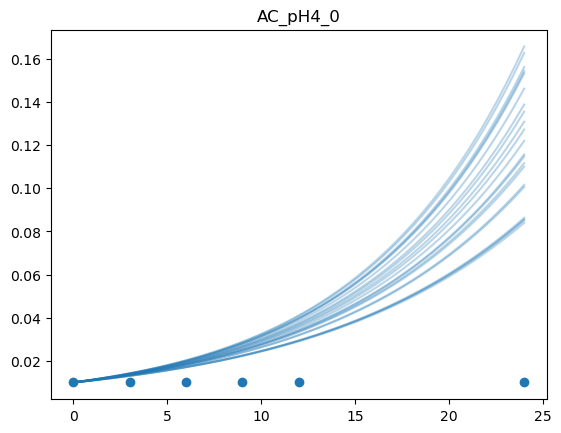

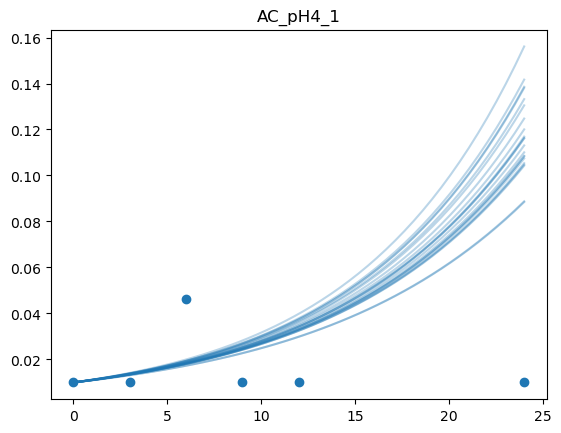

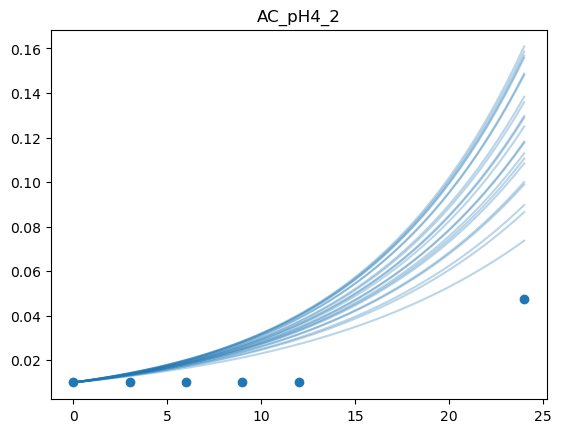

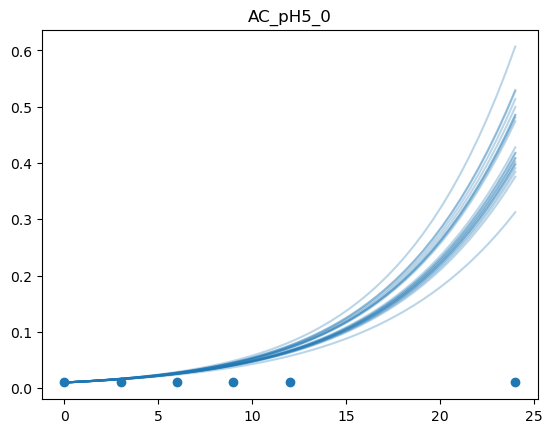

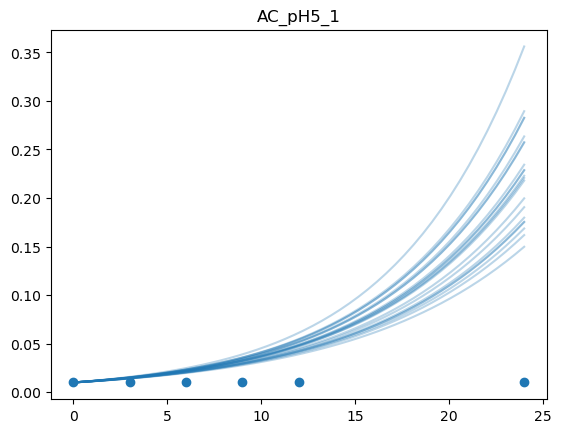

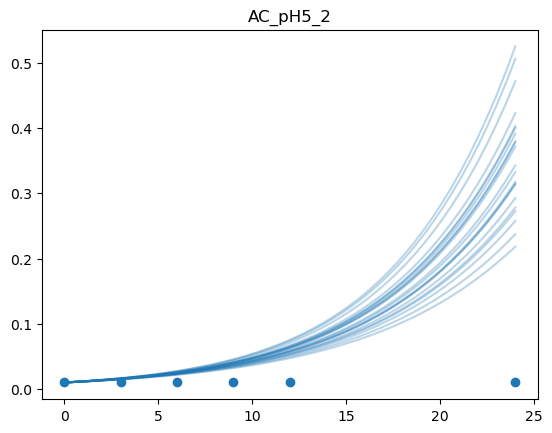

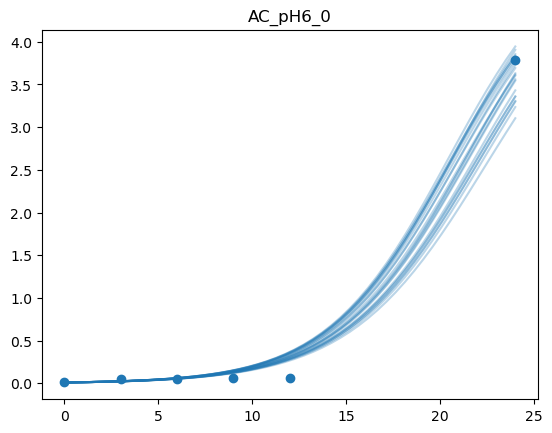

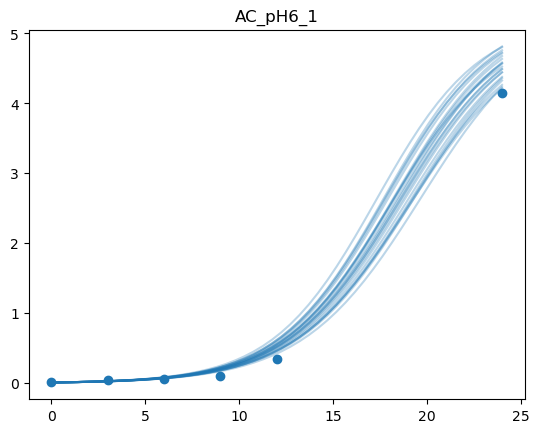

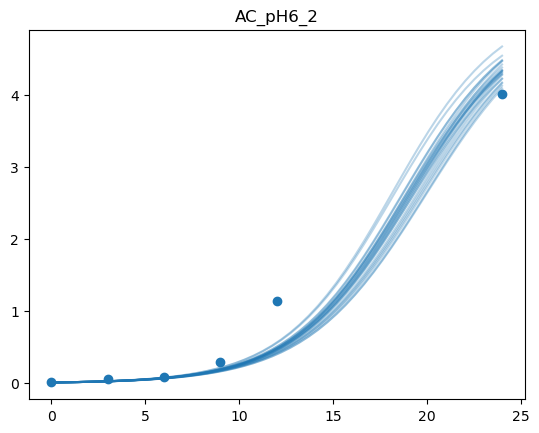

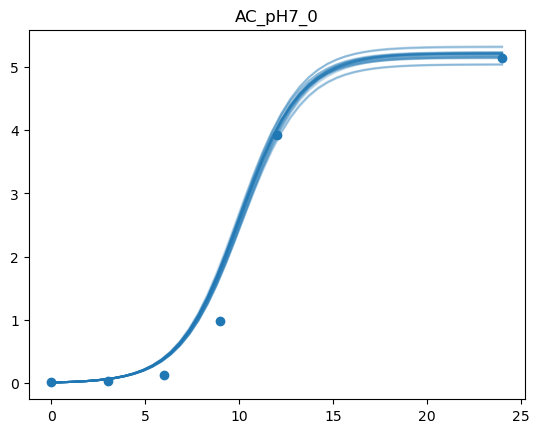

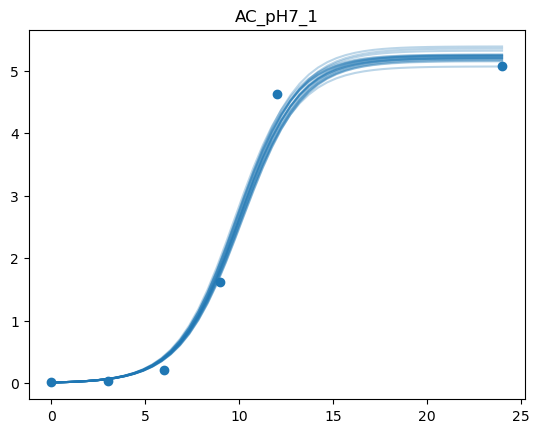

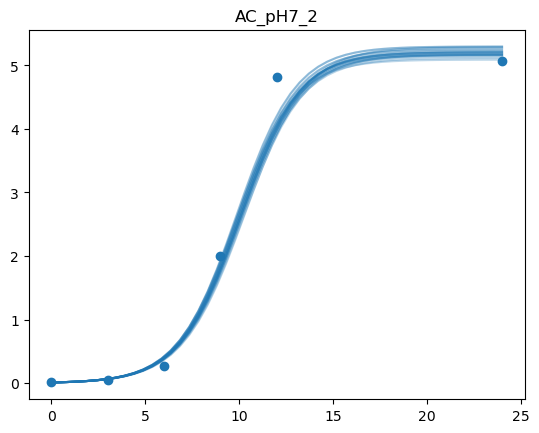

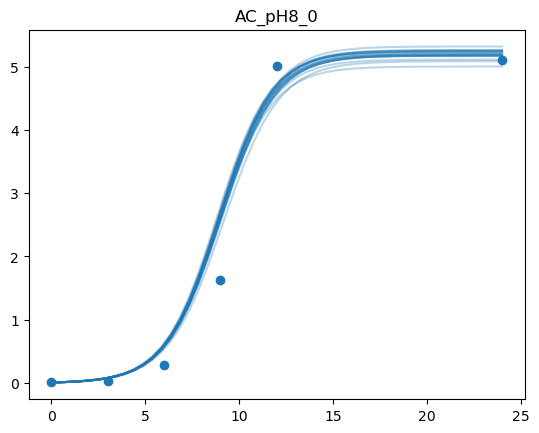

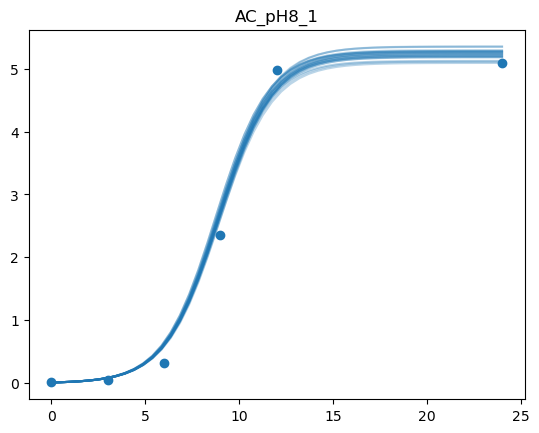

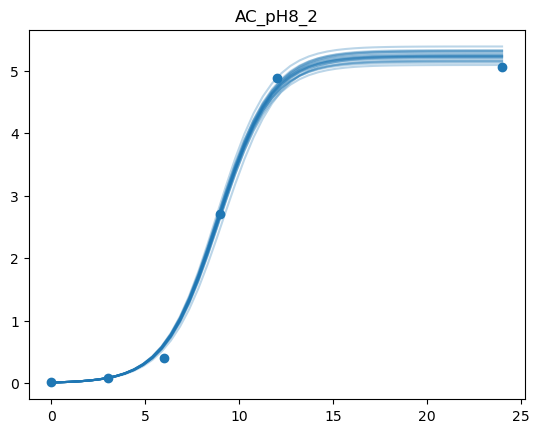

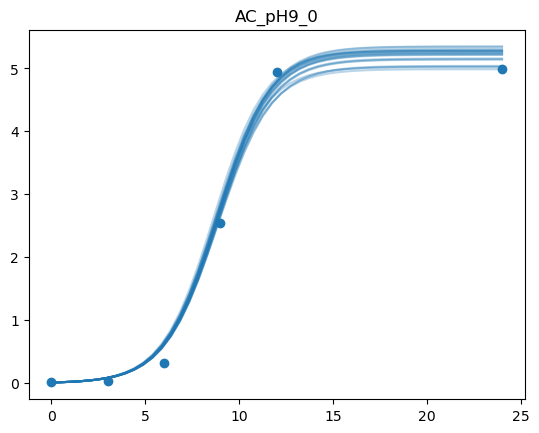

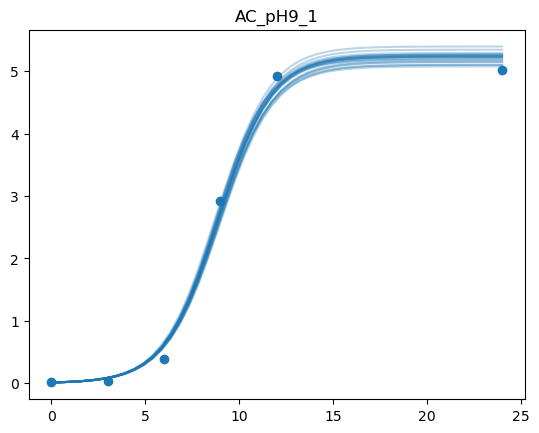

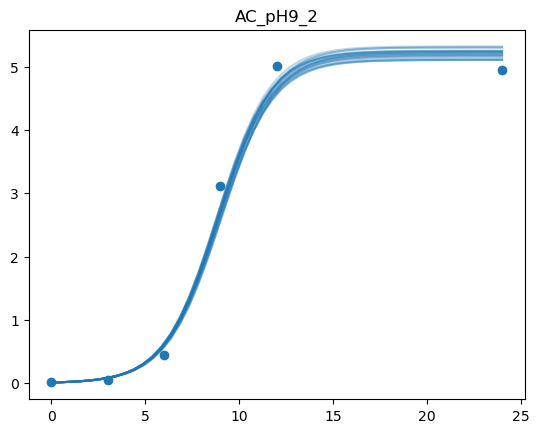

In [8]:
# random conditions to plot
# plt_conditions = np.random.choice(np.unique(df.Treatments.values), 5, replace=False)

# for exp_name in plt_conditions:
for exp_name, exp_df in df_AC.groupby("Treatments"):
    # pull dataframe
    # exp_df = df.iloc[df.Treatments.values==exp_name].copy()
    
    # predict values
    x0 = exp_df[species].values[0]
    t_eval = np.linspace(0., max(exp_df.Time.values))
    y_preds = ode_model.predict_sample(x0, t_eval)
    
    # plot 
    for i, s in enumerate(species[:1]):
        plt.scatter(exp_df.Time.values, exp_df[s].values)
        for y_pred in y_preds:
            plt.plot(t_eval, y_pred[:, i], alpha=.3, c=f'C{i}')
    
    plt.title(exp_name)
    plt.show()

## Save parameter values

In [9]:
# Define names of parameters 
df_params = ode_model.param_df()
df_params

,mean,stdv
0,1.033294,0.005751
1,7.179889,0.013725
2,0.186110,0.003301
3,0.197752,0.002485
4,0.314137,0.003998
